### Introduction

This dataset contains information regarding customers of a Portugese Bank. Features include personal information (job, marital status, etc.) as well as information regarding previous marketing campaigns.

The goal of this notebook is to try to predict if a customer will subscribe to a term deposit; this is a binary classification problem.

Raw data downloaded from: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

This Notebook includes:

1) Preprocessing such as removing outliers, creating dummy variables and feature selection.

2) Machine Learning using Logistic Regression, Random Forest, SVC, Gradient Boosting and Neural Networks

### Import libraries and data

In [1]:
# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# additional features
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# algorithms
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# silence warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import data
morig = pd.read_csv('bank-full.csv', sep=';')

print(morig.shape)

morig.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# no missing data in dataset
morig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Understanding categorical data

no     39922
yes     5289
Name: y, dtype: int64


Percentage of yes: 11.7%


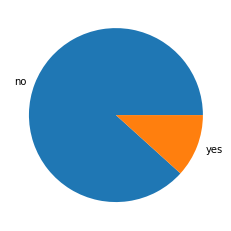

In [4]:
# distribution of target; whether a client subscribed a term deposit
# target is unbalanced
print(morig.y.value_counts())
print('\n')
print(f'Percentage of yes: {round((morig.y.value_counts()[1] / len(morig))*100, 2)}%')

plt.pie(morig.y.value_counts(), labels=morig.y.value_counts().index)
plt.show()

In [5]:
# job
print(f'Number of unique values for job: {len(morig.job.unique())}')
morig.job.value_counts()

Number of unique values for job: 12


blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [6]:
# marital
morig.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [7]:
# education
# although it is not labled as NaN, category 'unknown' is technically missing data
morig.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [8]:
# credit default
default_vc = morig.default.value_counts()
print(f'Credit in default is {round((default_vc[1] / default_vc.sum())*100, 2)} percent of observations')

Credit in default is 1.8 percent of observations


In [9]:
# has housing loan
morig.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [10]:
# has personal loan
morig.loan.value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

### Visualising numeric data

The median age of observations is 39.0


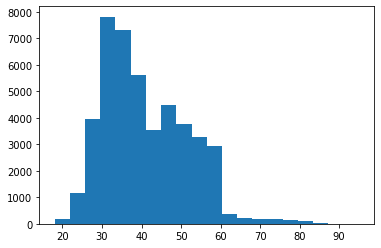

In [11]:
# age histogram and median age gives us an idea of age distribution
# higher end of age isn't an outlier, but may skew our results
print(f'The median age of observations is {morig.age.median()}')

plt.hist(morig.age, bins=20)
plt.show()

The median balance amount of observations is €448


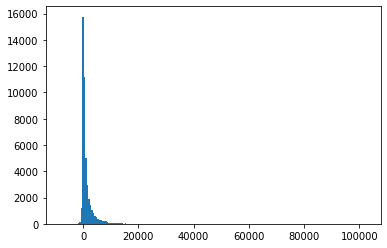

In [12]:
# severe outliers for average yearly balance
print(f'The median balance amount of observations is €{int(morig.balance.median())}')

plt.hist(morig.balance, bins=200)
plt.show()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64


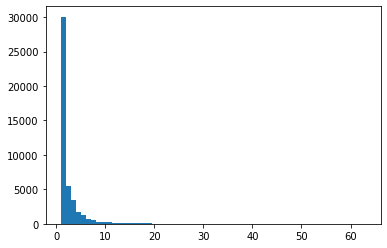

In [13]:
# campaign - number of contacts performed during this campaign and for this client
# all observations contacted at least once (min == 1)
print(morig.campaign.describe())
plt.hist(morig.campaign, bins=60)
plt.show()

In [14]:
# these columns relate to previous campaigns
print(f'No prior info for pdays: {len(morig[morig.pdays == -1])}')
print(f'No prior info for previous: {len(morig[morig.previous == 0])}')
print(f'No prior info for poutcome: {len(morig[morig.poutcome == "unknown"])}')

No prior info for pdays: 36954
No prior info for previous: 36954
No prior info for poutcome: 36959


### Preprocess data

In [15]:
# make a copy of data to be edited
medit = morig.copy()

In [16]:
# remove contact, day, month columns as they do not provide much predictive quality
# remove previous campaign columns due to large percentage of missing data
medit.drop(columns=['contact', 'day', 'month'], inplace=True)
medit.drop(columns=['pdays', 'previous', 'poutcome'], inplace=True)

medit.head(2)

,age,job,marital,education,default,balance,housing,loan,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,261,1,no
1,44,technician,single,secondary,no,29,yes,no,151,1,no


In [17]:
# remove balance outliers > €40K and < €-2K
medit = medit[(medit.balance <= 40000) & (medit.balance >= -2000)]

print(f'Dataset shape after removing balance outliers: {medit.shape}')

Dataset shape after removing balance outliers: (45169, 11)


In [18]:
# visualise campaign outliers
medit.campaign.value_counts().sort_index(ascending=False)[:20]

63     1
58     1
55     1
51     1
50     2
46     1
44     1
43     3
41     2
39     1
38     3
37     2
36     4
35     4
34     5
33     6
32     9
31    11
30     8
29    16
Name: campaign, dtype: int64

In [19]:
# remove campaign outliers >= 35
medit = medit[medit.campaign < 35]

print(f'Dataset shape after removing campaign outliers: {medit.shape}')

Dataset shape after removing campaign outliers: (45142, 11)


In [20]:
# drop unknowns in job
medit = medit[medit.job != 'unknown']

print(f'Dataset shape after removing job == unknown: {medit.shape}')

Dataset shape after removing job == unknown: (44855, 11)


In [21]:
# replace unknowns in education with most common education type
medit.education.replace(to_replace='unknown', value=medit.education.mode().values[0], inplace=True)

medit.education.value_counts()

secondary    24833
tertiary     13233
primary       6789
Name: education, dtype: int64

In [22]:
# use mapping to transform yes/no to binary
mapping = {'no': 0, 'yes': 1}

medit.replace({'no': 0, 'yes': 1}, inplace=True)

medit.head(2)

,age,job,marital,education,default,balance,housing,loan,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,261,1,0
1,44,technician,single,secondary,0,29,1,0,151,1,0


In [23]:
# convert categoric data to dummy variables
medit = pd.get_dummies(medit, columns=['job', 'marital', 'education'], drop_first=True)

medit.head(2)

,age,default,balance,housing,loan,duration,campaign,y,job_blue-collar,job_entrepreneur,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary
0,58,0,2143,1,0,261,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,44,0,29,1,0,151,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0


In [24]:
# designate target and features
mtarget = medit.y
medit.drop(columns=['y'], inplace=True)

In [25]:
# minmax normalisation
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(medit)
medit = pd.DataFrame(scaled)

medit.head(2)

C:\Users\liamk\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.519481,0.0,0.099674,1.0,0.0,0.053070,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.337662,0.0,0.048568,1.0,0.0,0.030704,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [26]:
# using chi square for feature selection
mkbest = SelectKBest(chi2, k=16).fit_transform(medit, mtarget)

mkbest[:2]

array([[0.        , 1.        , 0.        , 0.05307035, 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.        , 0.03070354, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 1.        ,
        0.        ]])

### Train Test Split

In [27]:
# split train and test data
# test is 25% of data; random state is specified for consistent result during experimenting
x_train, x_test, y_train, y_test = train_test_split(mkbest, mtarget, test_size=0.25, random_state=0)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(33641, 16) (11214, 16) (33641,) (11214,)


### Logistic Regression

In [28]:
# class_weight specified due to imbalanced target
# also experimented with manually assigning {class_label: weight}
lr = LogisticRegression(fit_intercept=True, class_weight='balanced')

In [29]:
lr.fit(x_train, y_train)
print(f'Logistic Regression Coefficients: {lr.coef_[0]}')
print('\n')
print(f'Logistic Regression Intercept:{lr.intercept_}')

Logistic Regression Coefficients: [-5.07122934e-01 -1.02010999e+00 -7.85646889e-01  2.30388171e+01
 -5.25831146e+00 -4.35693194e-01 -5.00779737e-01  4.61665542e-03
  7.05838867e-01 -2.22739143e-01  8.25626973e-01  1.14036207e-01
 -6.61127995e-02  2.65650270e-01  3.31826140e-01  6.24458662e-01]


Logistic Regression Intercept:[-1.21644631]


In [30]:
# Logistic Regression train and test performance
# class_weight='balanced' yields lower train and test accuracy, but better sensitivity
print("Logreg training mean accuracy: %.4f" % lr.score(x_train, y_train))
print("Logreg test mean accuracy: %.4f" % lr.score(x_test, y_test))

Logreg training mean accuracy: 0.7924
Logreg test mean accuracy: 0.7896


In [31]:
# if I gussed 'no' for all predictions, I would still have an accuracy of 88%
# therefore accuracy alone is not enough
print(f'Baseline score to beat: {round(morig.y.value_counts()[0] / morig.y.value_counts().sum(), 4)}')

Baseline score to beat: 0.883


In [32]:
# create Logistci Regression predictions
y_pred = lr.predict(x_test)

y_pred[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [33]:
print(f'# of true cases in y_test: {len(y_test[y_test == 1])}')

# of true cases in y_test: 1310


In [34]:
# Logistic Regression Confusion Matrix
# Good identification of true cases with high True Positive number of 989
print(confusion_matrix(y_test, y_pred))

[[7866 2038]
 [ 321  989]]


<b>Sensitivity:</b> The ability of a model to determine true cases correctly.

Sensitivity  = TP / (TP + FN)

In [35]:
lr_cm = confusion_matrix(y_test, y_pred)

print(f'Logreg Sensitivity: {round(lr_cm[1][1] / (lr_cm[1][1] + lr_cm[1][0]), 4)}')

Logreg Sensitivity: 0.755


In [36]:
# ROC Curve
# another good indicator of performance for unbalanced targets
lr_prob_y = lr.predict_proba(x_test)
lr_prob_y = [p[1] for p in lr_prob_y]

print(f'Logreg ROC: {round(roc_auc_score(y_test, lr_prob_y), 4)}')

Logreg ROC: 0.8488


### Random Forest

In [37]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
# Random forest is overfitting, causing drastic difference in performance between train and test set
print("Random Forest training mean accuracy: %.4f" % rfc.score(x_train, y_train))
print("Random Forest test mean accuracy: %.4f" % rfc.score(x_test, y_test))

Random Forest training mean accuracy: 0.9713
Random Forest test mean accuracy: 0.8605


In [39]:
# Random Forest Confusion Matrix
# lower True Positive numbers
rfc_y_pred = rfc.predict(x_test)

print(confusion_matrix(y_test, rfc_y_pred))

[[9301  603]
 [ 961  349]]


In [40]:
# as a result Random Forest's sensitivity is very low
rf_cm = confusion_matrix(y_test, rfc_y_pred)

print(f'Random Forest Sensitivity: {round(rf_cm[1][1] / (rf_cm[1][1] + rf_cm[1][0]), 4)}')

Random Forest Sensitivity: 0.2664


In [41]:
# Random Forest performs poorly according to ROC
rfc_prob_y = rfc.predict_proba(x_test)
rfc_prob_y = [p[1] for p in rfc_prob_y]
print(f'Random Forest ROC: {round(roc_auc_score(y_test, rfc_prob_y), 4)}')

Random Forest ROC: 0.7389


### SVC

<font color='red'>Notice: SVC requires longer runtime as it is creating hyperplane separator in data's high dimensional space.</font>

In [42]:
svc = SVC(kernel='linear', class_weight='balanced', probability=True)
 
svc.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [43]:
# SVC performs quite well 
# SVC has higher True Positive than weighted Logistic Regression but slightly lower Sensitivity
print("SVC training mean accuracy: %.4f" % svc.score(x_train, y_train))
print("SVC test mean accuracy: %.4f" % svc.score(x_test, y_test))
print('\n')
print('SVC Confusion Matrix')
svc_y_pred = svc.predict(x_test)
print(confusion_matrix(y_test, svc_y_pred))
print('\n')
svc_cm = confusion_matrix(y_test, svc_y_pred)
print(f'SVC Sensitivity: {round(svc_cm[1][1] / (svc_cm[1][1] + svc_cm[1][0]), 4)}')
print('\n')
svc_prob_y = svc.predict_proba(x_test)
svc_prob_y = [p[1] for p in svc_prob_y]
print(f'SVC ROC: {round(roc_auc_score(y_test, svc_prob_y), 4)}')

SVC training mean accuracy: 0.7855
SVC test mean accuracy: 0.7821


SVC Confusion Matrix
[[7765 2139]
 [ 304 1006]]


SVC Sensitivity: 0.7679


SVC ROC: 0.8501


### Gradient Boosting

In [44]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)

print("Gradient Boosting training set score: %f" % gbc.score(x_train, y_train))
print("Gradient Boosting test set score: %f" % gbc.score(x_test, y_test))

Gradient Boosting training set score: 0.893404
Gradient Boosting test set score: 0.891297


In [45]:
# Gradient Boosting Confusion Matrix
# True Positive is lower than Logistic Regression and SVC
gbc_y_pred = gbc.predict(x_test)

print(confusion_matrix(y_test, gbc_y_pred))

[[9670  234]
 [ 985  325]]


In [46]:
gbc_prob_y = gbc.predict_proba(x_test)
gbc_prob_y = [p[1] for p in gbc_prob_y]

print(f'Gradient Boosting ROC: {round(roc_auc_score(y_test, gbc_prob_y), 4)}')

Gradient Boosting ROC: 0.8592


### Nueral Network

In [47]:
# multiple attempts with different hidden layer configurations
# constantly unable to converge
mlp = MLPClassifier(hidden_layer_sizes=(12, 8, 4), max_iter=30, alpha=1e-4, activation='tanh',
                    solver='sgd', verbose=10, tol=1e-4, random_state=0,
                    learning_rate_init=.2)

mlp.fit(x_train, y_train)

Iteration 1, loss = 0.35159972
Iteration 2, loss = 0.29736917
Iteration 3, loss = 0.28016289
Iteration 4, loss = 0.27514026
Iteration 5, loss = 0.27259389
Iteration 6, loss = 0.27169504
Iteration 7, loss = 0.27079640
Iteration 8, loss = 0.26837187
Iteration 9, loss = 0.26826294
Iteration 10, loss = 0.26801599
Iteration 11, loss = 0.26680633
Iteration 12, loss = 0.26688649
Iteration 13, loss = 0.26815439
Iteration 14, loss = 0.26632940
Iteration 15, loss = 0.26727341
Iteration 16, loss = 0.26624892
Iteration 17, loss = 0.26581512
Iteration 18, loss = 0.26535982
Iteration 19, loss = 0.26540220
Iteration 20, loss = 0.26472307
Iteration 21, loss = 0.26511491
Iteration 22, loss = 0.26432448
Iteration 23, loss = 0.26438667
Iteration 24, loss = 0.26480270
Iteration 25, loss = 0.26399676
Iteration 26, loss = 0.26343186
Iteration 27, loss = 0.26364401
Iteration 28, loss = 0.26345429
Iteration 29, loss = 0.26318855
Iteration 30, loss = 0.26341295


C:\Users\liamk\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 8, 4), learning_rate='constant',
       learning_rate_init=0.2, max_iter=30, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=10, warm_start=False)

In [48]:
# NN Test and train performance
print("Neural Network training mean accuracy: %.4f" % mlp.score(x_train, y_train))
print("Neural Network test mean accuracy: %.4f" % mlp.score(x_test, y_test))

Neural Network training mean accuracy: 0.8872
Neural Network test mean accuracy: 0.8870


In [49]:
# NN Confusion Matrix
# Better performance than Gradient Boosting and Random Forest, but worse than Logistic Regression and SVC
mlp_y_pred = mlp.predict(x_test)

print(confusion_matrix(y_test, mlp_y_pred))

[[9501  403]
 [ 864  446]]


In [50]:
mlp_prob_y = mlp.predict_proba(x_test)
mlp_prob_y = [p[1] for p in mlp_prob_y]

print(f'Nueral Network ROC: {round(roc_auc_score(y_test, mlp_prob_y), 4)}')

Nueral Network ROC: 0.8487


### Cross Valiadtion

In [51]:
lr_cross_val = cross_val_score(lr, mkbest, mtarget, cv=5)

print('Logistic Regression Cross Val Individual Scores:')
print(list(lr_cross_val))

Logistic Regression Cross Val Individual Scores:
[0.8478600089166295, 0.7840820421357708, 0.7076134210232973, 0.7585553450005573, 0.749386845039019]


<font color='red'>Notice: SVC cross val is commented out due to long runtime.</font>
<br>
<font color='red'> SVC Cross val result is: [0.84741418, 0.77471854, 0.66202207, 0.75866682, 0.7567447 ]</font>

In [52]:
# svc_cross_val = cross_val_score(svc, mkbest, mtarget, cv=5)

# print('SVC Cross Val Individual Scores:')
# print(list(svc_cross_val))

Cross Validation for both Logistic Regression and SVC aren't very consistent which isn't ideal.

### Conclusion

Binary Classification for this dataset is made more difficult due to class imbalance (roughly 12% true cases). Therefore mean accuracy alone is not reliable for judging algorithm performance. Confusion matrix and ROC score are used to supplement decision making.

Predicting true positives was more accurate for Weighted Logistic Regression and SVC, although cross validation reveals some consistency issues. Nueral Network performance was ok, and Random Forest and Gradient Boosting performing poorly.

Prediction on only observations with previous campaign data could have yielded better results, however that would ignore around 37K rows of missing data (80% of dataset), so it was decided to drop the previous campaign columns instead.

Overall this coursework was challenging but taught many good lessons on how to deal with imbalanced classes. Thank you for reviewing this notebook!